# FLUSS Segmentation
In this notebook, we use the FLUSS algorithm from the stumpy package to segment the challenge data.

In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
%config InlineBackend.figure_formats = {'png', 'retina'}

import stumpy
from sktime.annotation.plotting.utils import plot_time_series_with_change_points
from sktime.annotation.clasp import find_dominant_window_sizes

from utils import load_data, to_submission

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


First, we load the 250 time series (TS) as a pandas DataFrame. Each row corresponds to a twelve-dimensional TS and every column contains one channel of sensor data.

In [2]:
df = load_data()
# df.head()

For demonstration, we segment one channel and only a subset of the 250 TS. We plot the segmentations and store the change points (CPs) for the submission.

Using channel: y-acc


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


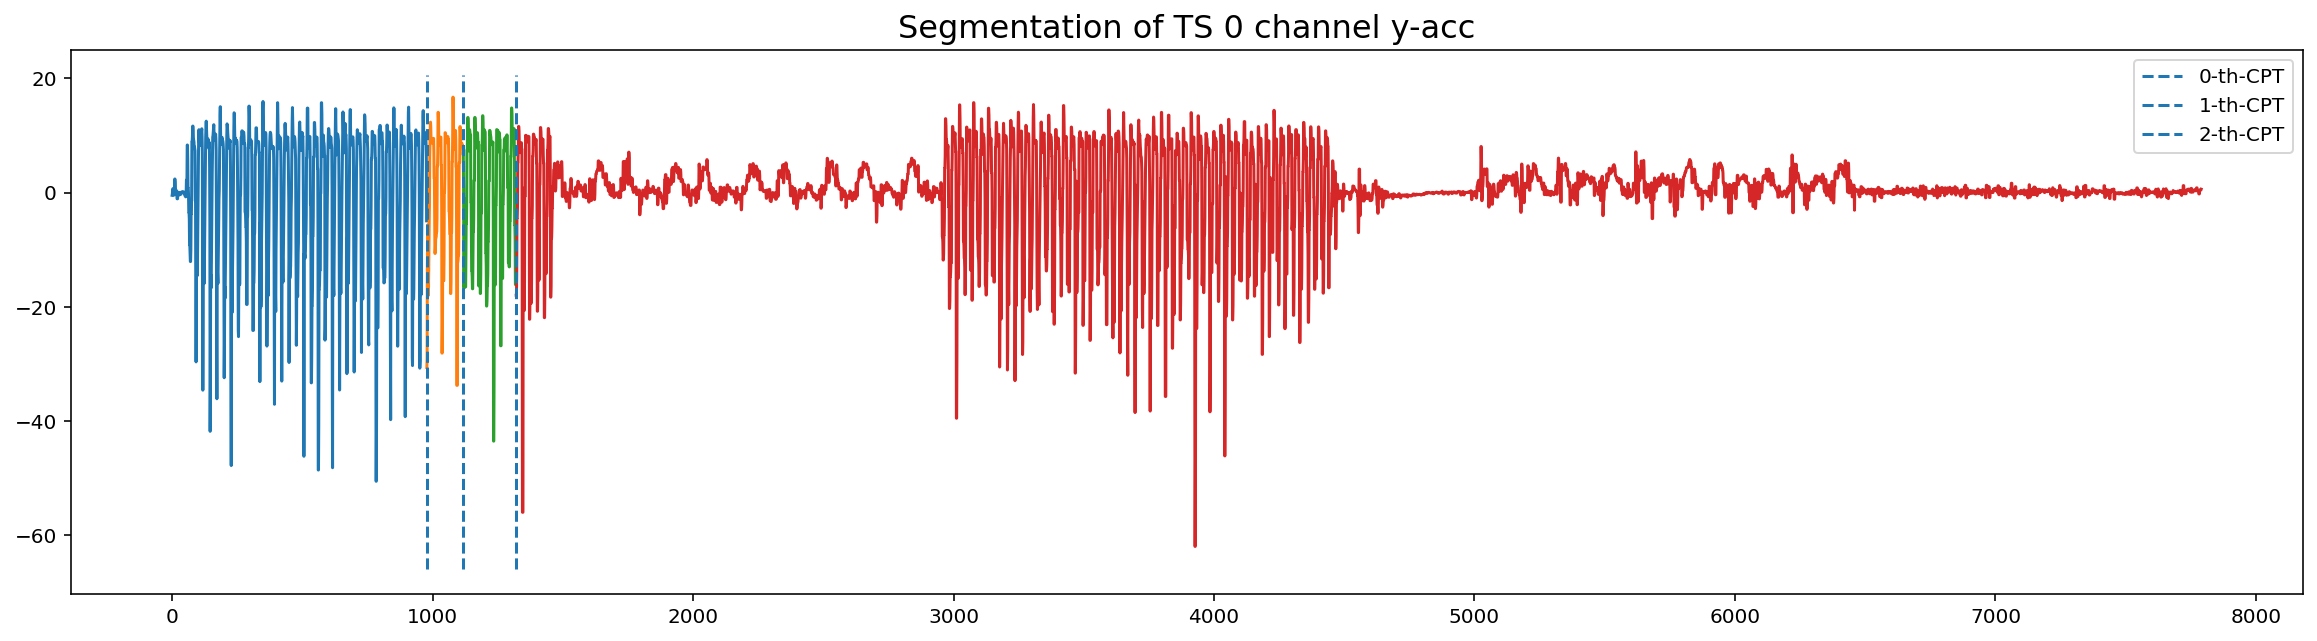

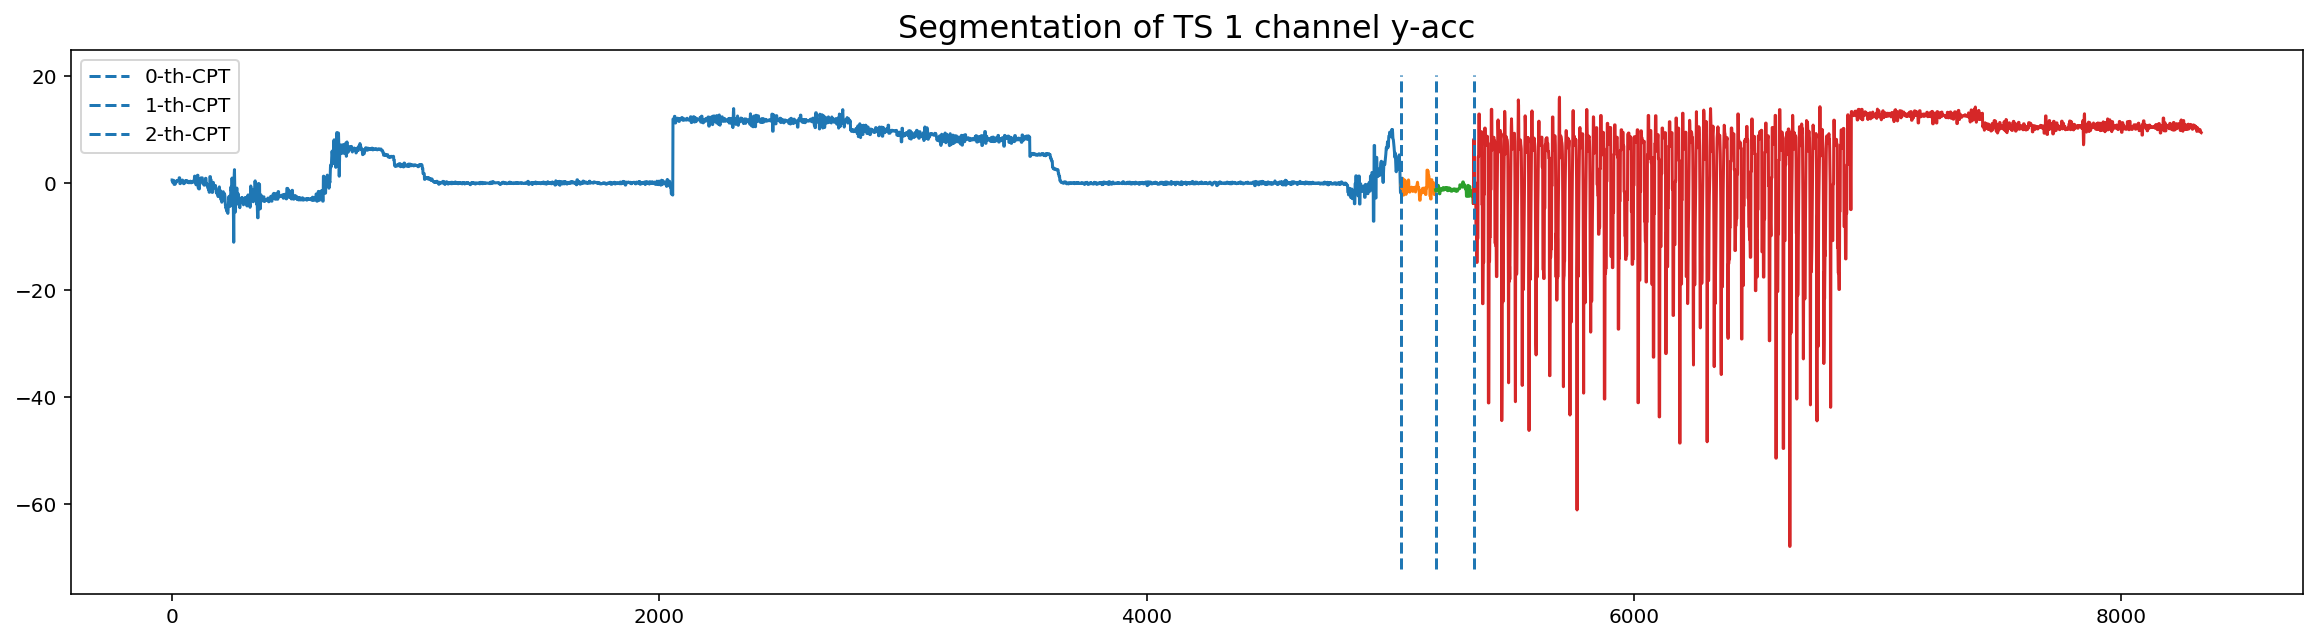

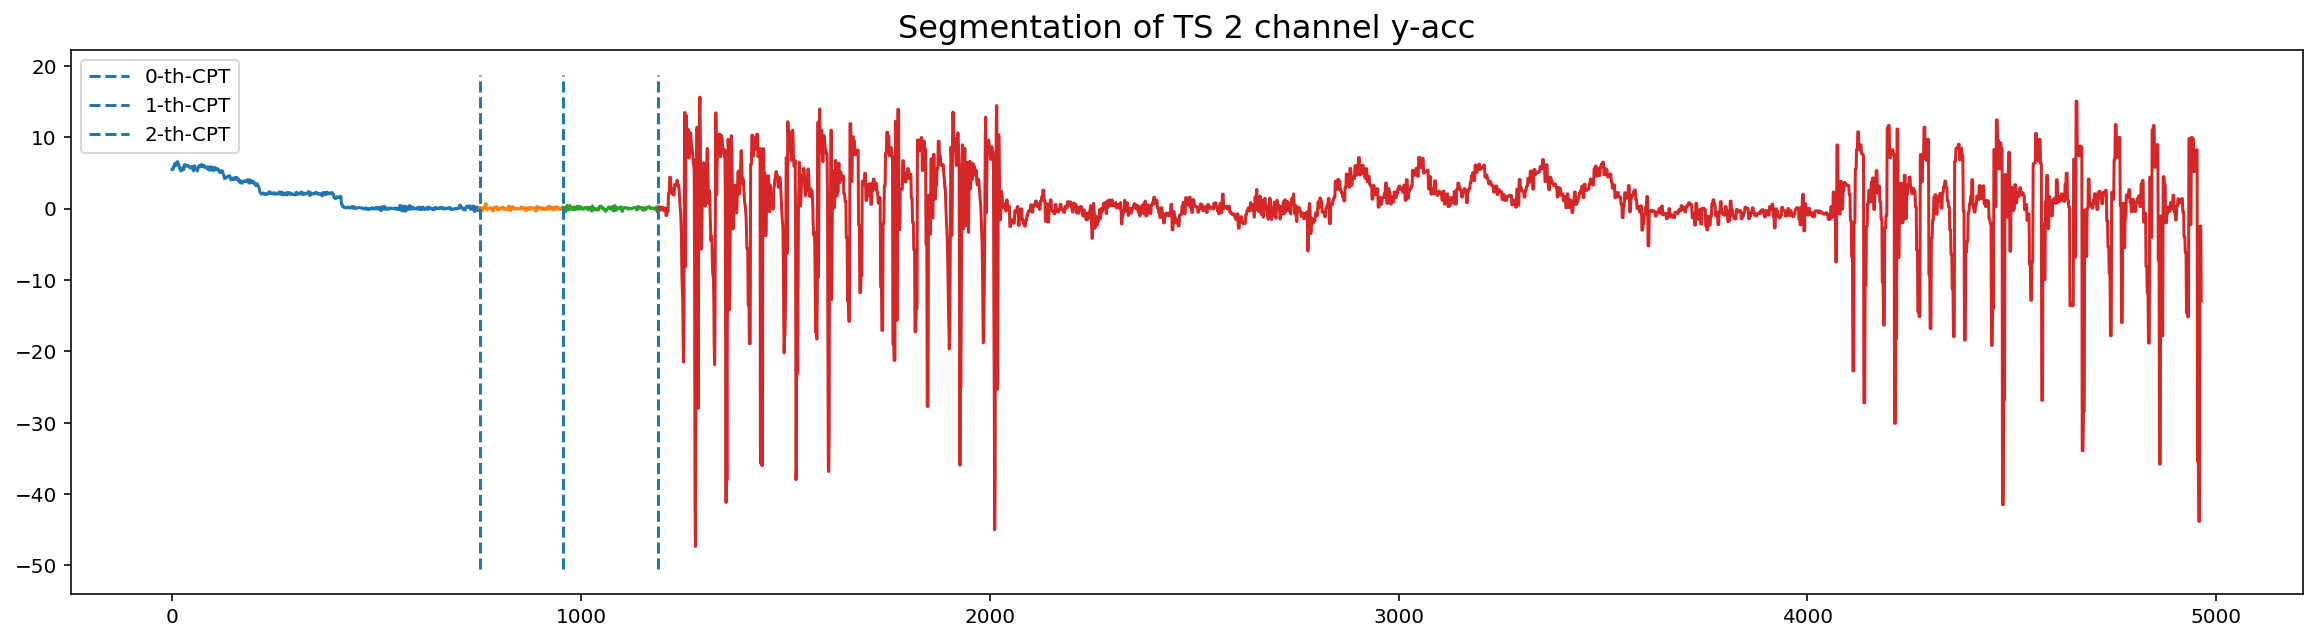

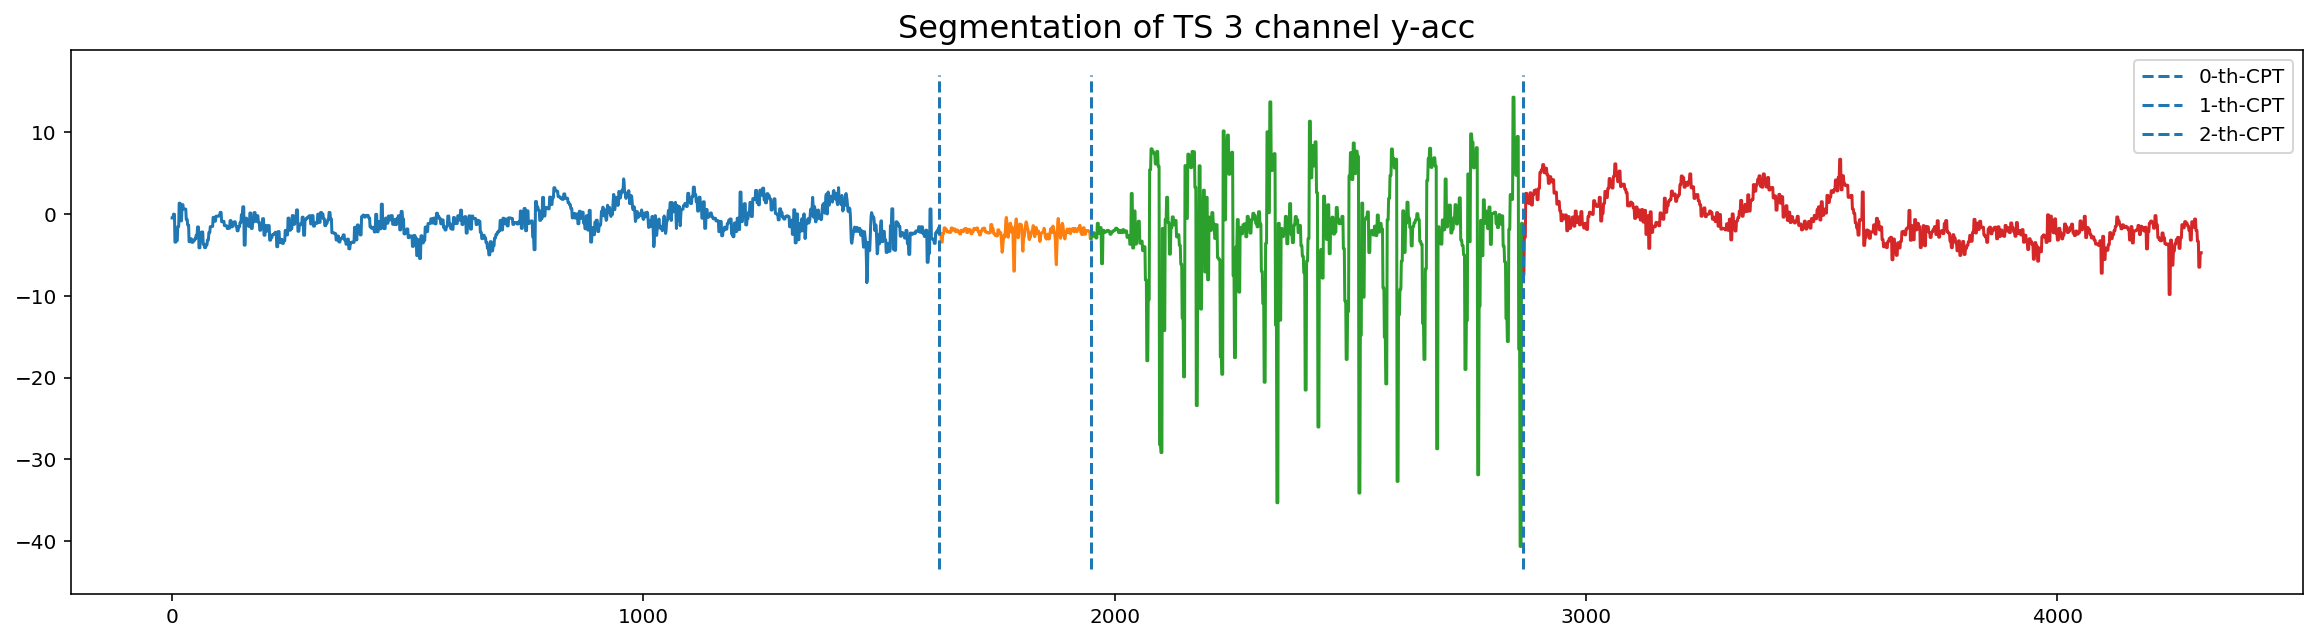

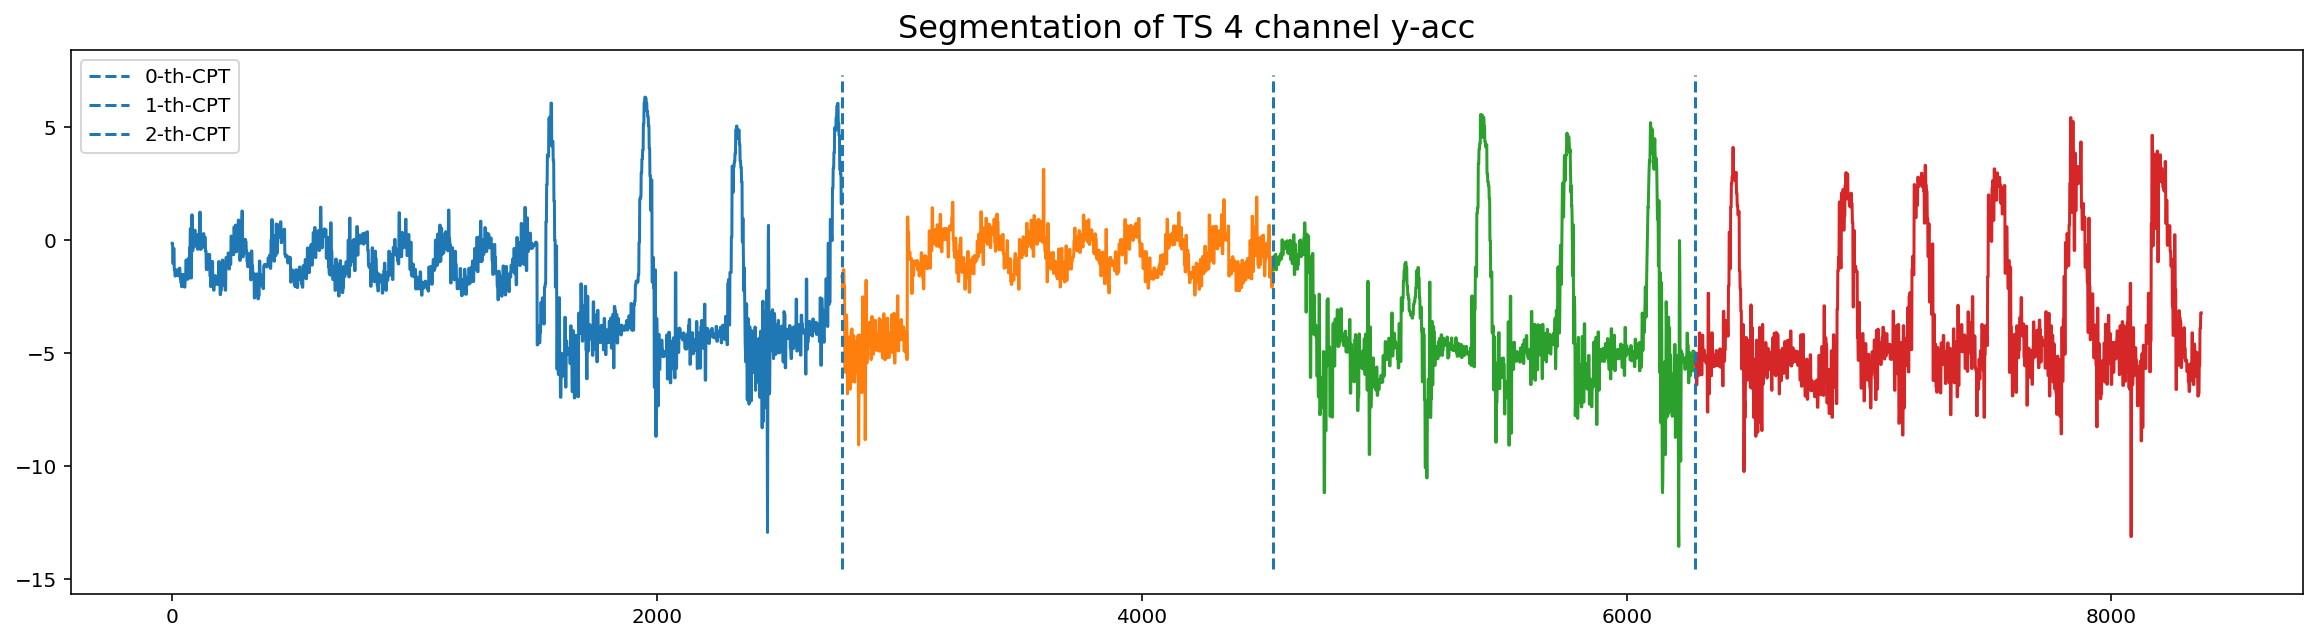

In [3]:
# use only one channel
channel = "y-acc"
# channels = ["x-acc", "y-acc", "z-acc", "x-gyro", "y-gyro", "z-gyro"]
print(f"Using channel: {channel}")

# segment the first 5 TS
subset = 5
change_points = []

for idx, row in df.iloc[:subset,:].iterrows():
    ts = row[channel]

    window_size = min(find_dominant_window_sizes(ts) * 2, len(ts) // 2)
    mp = stumpy.stump(ts, m=window_size)
    cac, found_cps = stumpy.fluss(mp[:, 1], L=window_size, n_regimes=4)
    change_points.append(found_cps)

    fig, ax = plot_time_series_with_change_points(
        f"Segmentation of TS {idx} channel {channel}", pd.Series(ts), found_cps)

    plt.show()

To make a submission, simply run the last cell for all 250 TS and then format the CPs in the correct way and hand in your results.

In [4]:
submission = to_submission(df.iloc[:subset,:], change_points)
submission.head()
# submission.to_csv("submission.csv", index=False)

,Id,Offsets
0,0,1 978
1,0,979 140
2,0,1119 203
3,0,1322 6469
4,1,1 5045
